In [1]:
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

from PIL import Image
import cv2
from skimage import io
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

In [2]:
def indice(x, df, num_of_species=12):
    
    """
    Fonction retournant x indices d'images aléatoires par espèce d'un dataframe
    """
    
    if num_of_species > 12:
        print("Il n'y a que 12 espèces.")
    
    elif x > min(df.species.value_counts()):
        print("Le dataset ne contient que ",df.species.value_counts().sort_values()[0], df.species.value_counts().sort_values().index[0], ".")
    
    else:
        indices = []
        for s in np.random.choice(df.species.unique(), size=num_of_species, replace=False):
            for i in range(x):
                idx = np.random.choice(df[df.species == s].index, replace = False)
                indices.append(idx)
        return indices

In [3]:
#fonction pour produire le mask par seuillage
def preprocessing_with_tsegm(input_img, threshold = 118):
    
    """
    Fonction de preprocessing comprenant la segmentation par seuillage colorimétrique 
    ainsi que les transformations géométriques d'ouverture/fermeture
    Prend en entrée une image qui sera redimensionnée et renvoie le masque associé.
    """
    
    # Etape 1: Segmentation simple par seuillage
    img_rgb = np.uint8(input_img)
    img_rgb = cv2.resize(img_rgb,(224,224))
    img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2LAB)
    
    # Création du masque par seuillage
    _,mask = cv2.threshold(img_lab[:,:,1],threshold,255,cv2.THRESH_BINARY_INV)
    
    # Elimination du bruit par ouverture puis fermeture
    kernel = np.ones((2,2))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask
    

In [4]:
df = pd.read_csv('V2_Plant_Seedlings_DataFrame.csv')
df.head()

,filepath,species,image_name,height,width,image_size,square,R_mean,V_mean,B_mean,blur_score,luminosity,sharpness_score
0,C:\V2 Plant Seedlings Dataset\Black-grass\1.png,Black-grass,1.png,138,138,19044,square,105.075247,98.336957,89.631590,151.874492,97.681264,8.365028
1,C:\V2 Plant Seedlings Dataset\Black-grass\10.png,Black-grass,10.png,1040,1040,1081600,square,79.711614,68.709711,60.161677,133.348355,69.527667,367.182903
2,C:\V2 Plant Seedlings Dataset\Black-grass\100.png,Black-grass,100.png,82,82,6724,square,111.598602,103.431440,92.232302,131.975238,102.420781,2.803053
3,C:\V2 Plant Seedlings Dataset\Black-grass\101.png,Black-grass,101.png,156,156,24336,square,84.529668,67.176446,48.901833,132.849602,66.869316,8.426078
4,C:\V2 Plant Seedlings Dataset\Black-grass\102.png,Black-grass,102.png,197,197,38809,square,88.982092,72.174805,53.490505,108.609648,71.549134,12.779936


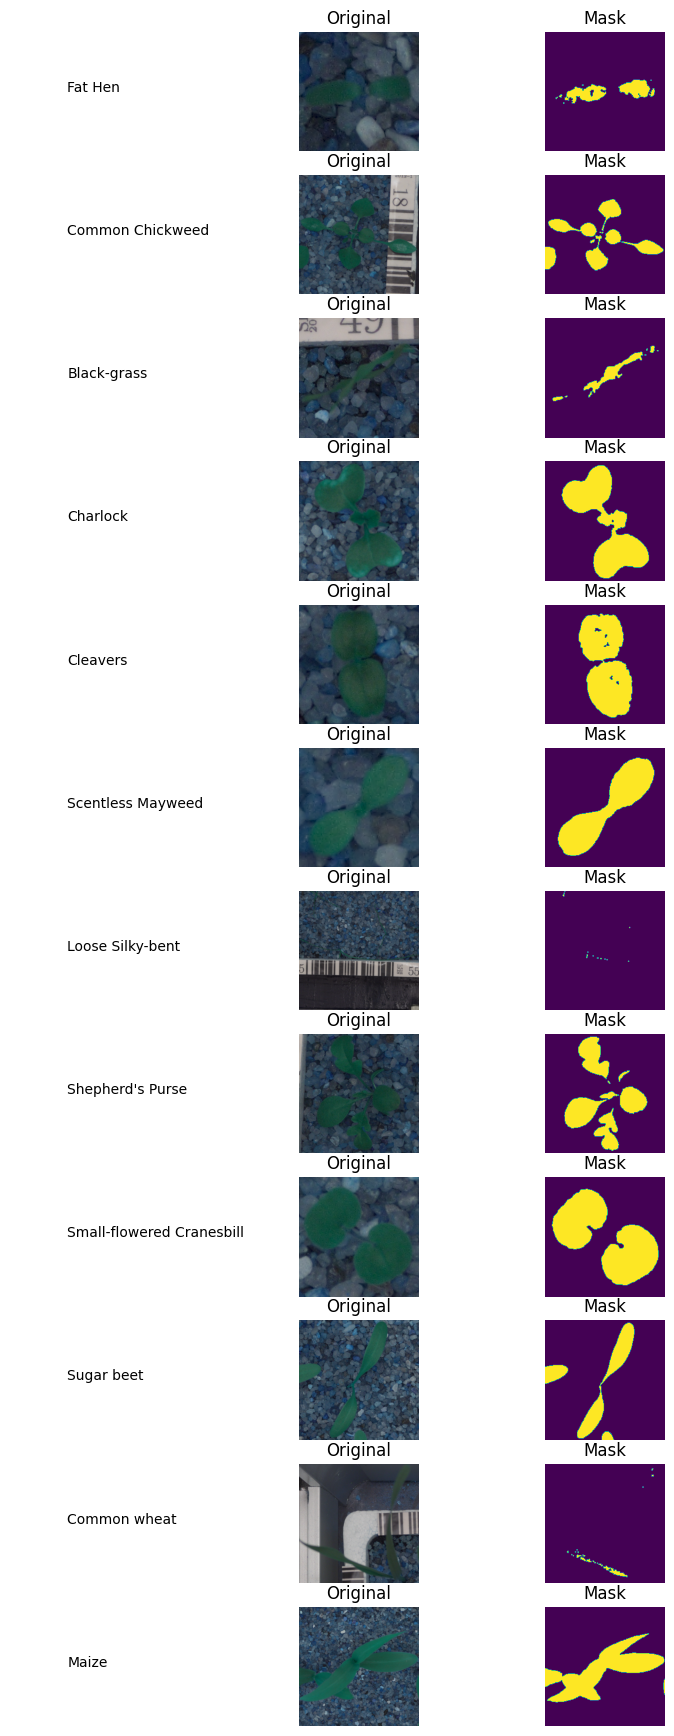

In [5]:
# Visualisation de couples d'image + le mask associé
fig, ax = plt.subplots(12,3, figsize=(9, 22))

for i, idx in enumerate(indice(1, df, 12)):
    im = cv2.imread(df.filepath[idx])
    img_mask = preprocessing_with_tsegm(im)
    ax[i, 1].imshow(im)
    ax[i, 1].set_title("Original")
    ax[i, 1].axis("off")
    ax[i, 0].text(0.28, 0.5, df.species[idx])
    ax[i, 0].axis('off')
        
    for j in range (2,3):
        ax[i, j].imshow(img_mask)
        ax[i, j].set_title("Mask")
        ax[i, j].axis("off")

# Création des données

In [7]:
# Création d'un DataFrame contenant le chemins des images et de leurs annotations. 


# Choisir l'emplacement et le nom du dossier à créer où contenir les masques
PATH = "C:\\Segmented" 

# Création du nouveau dossier où contenir les masques
os.mkdir(PATH)

# Création des folders
for dirname in df.species.unique():
      os.mkdir(PATH + "\\" + dirname)

names = []
filepaths_img = []
filepaths_img_seg = []
species = []

# Pour 250 images par espèce, enregistrer les masques générés
for idx in indice(250, df):
    filepath = df.filepath[idx]
    name = df.image_name[idx]
    specie = df.species[idx]
    
    im = cv2.imread(filepath)
    img_mask = preprocessing_with_tsegm(im)
    
    # Détourner la trajectoire du chemin d'enregistrement vers le bon dossier en fonction de l'espèce
    os.chdir(PATH + "\\" + df.species[idx])
    cv2.imwrite(name,img_mask)
    filepath_img_seg = os.path.abspath(name)
    
    # Ajout des élements aux listes associées
    names.append(name)
    filepaths_img.append(filepath)
    filepaths_img_seg.append(filepath_img_seg)
    species.append(specie)
    
# Remettre le chemin de travail en place
os.chdir("C:\\Users\\lecam\\Plantes")

# Création du DataFrame  
df_segmentation = pd.DataFrame({'filepath': filepaths_img, 'annotation':  filepaths_img_seg, 'name': names,'species' :species })
# Shuffle des lignes du DataFrame
df_segmentation = df_segmentation.sample(frac=1).reset_index(drop=True)
df_segmentation.head()

,filepath,annotation,name,species
0,C:\V2 Plant Seedlings Dataset\Small-flowered C...,C:\Segmented\Small-flowered Cranesbill\458.png,458.png,Small-flowered Cranesbill
1,C:\V2 Plant Seedlings Dataset\Black-grass\41.png,C:\Segmented\Black-grass\41.png,41.png,Black-grass
2,C:\V2 Plant Seedlings Dataset\Common Chickweed...,C:\Segmented\Common Chickweed\123.png,123.png,Common Chickweed
3,C:\V2 Plant Seedlings Dataset\Cleavers\98.png,C:\Segmented\Cleavers\98.png,98.png,Cleavers
4,C:\V2 Plant Seedlings Dataset\Sugar beet\202.png,C:\Segmented\Sugar beet\202.png,202.png,Sugar beet


In [8]:
#Sauvegarde du DataFrame
df_segmentation.to_csv('Plant_Mask_DataFrame.csv', index=False)

In [4]:
# Chargement du DataFrame
df_segmentation = pd.read_csv('Plant_Mask_DataFrame.csv')
df_segmentation.head()

,filepath,annotation,name,species
0,C:\V2 Plant Seedlings Dataset\Small-flowered C...,C:\Segmented\Small-flowered Cranesbill\458.png,458.png,Small-flowered Cranesbill
1,C:\V2 Plant Seedlings Dataset\Black-grass\41.png,C:\Segmented\Black-grass\41.png,41.png,Black-grass
2,C:\V2 Plant Seedlings Dataset\Common Chickweed...,C:\Segmented\Common Chickweed\123.png,123.png,Common Chickweed
3,C:\V2 Plant Seedlings Dataset\Cleavers\98.png,C:\Segmented\Cleavers\98.png,98.png,Cleavers
4,C:\V2 Plant Seedlings Dataset\Sugar beet\202.png,C:\Segmented\Sugar beet\202.png,202.png,Sugar beet


In [5]:
df_segmentation.species.value_counts()

Small-flowered Cranesbill    250
Black-grass                  250
Common Chickweed             250
Cleavers                     250
Sugar beet                   250
Loose Silky-bent             250
Fat Hen                      250
Shepherd's Purse             250
Charlock                     250
Common wheat                 250
Scentless Mayweed            250
Maize                        250
Name: species, dtype: int64

# Séparation et préparation des données

In [6]:
df_train, df_test = train_test_split(df_segmentation, test_size = 0.2)

In [7]:
print(df_train.shape)
print(df_test.shape)

(2400, 4)
(600, 4)


In [8]:
IMG_SHAPE = 224
BATCH_SIZE = 32

def load_and_preprocess(img_filepath, mask_filepath):
    
    """
    Prend un entrée les chemins d'accès d'une image et du masque associé,
    et renvoie le couple image/masque en question normalisé et redimensionné
    """
    
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    img = tf.cast(img, tf.float32)/255

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])
    mask = mask / 255

    return img, mask


def augmentation(img, mask):
    
    """
    Fonction destinée à augmentater le jeu de données.
    Renvoi un couple image/masque augmentés identiquement de manière aléatoire.
    """

    do_flip1 = tf.random.uniform([]) > 0.5
    do_flip2 = tf.random.uniform([]) > 0.5
    do_rotat = tf.random.uniform([]) > 0.5
    
    img = tf.cond(do_flip1, lambda: tf.image.flip_left_right(img), lambda: img)
    img = tf.cond(do_flip2, lambda: tf.image.flip_up_down(img), lambda: img)
    img = tf.cond(do_rotat, lambda: tf.image.rot90(img), lambda: img)
    
    mask = tf.cond(do_flip1, lambda: tf.image.flip_left_right(mask), lambda: mask)
    mask = tf.cond(do_flip2, lambda: tf.image.flip_up_down(mask), lambda: mask)
    mask = tf.cond(do_rotat, lambda: tf.image.rot90(mask), lambda: mask)
    
    return img, mask


# Instanciation des objets Datasets

input_img_paths_train, annotation_img_paths_train = df_train.filepath, df_train.annotation
train = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))

train = (
    train
    .map(load_and_preprocess, num_parallel_calls=-1)
    .map(augmentation, num_parallel_calls=-1)
    .batch(32)
    .shuffle(buffer_size=40)
    .prefetch(-1)
)


input_img_paths_test, annotation_img_paths_test = df_test.filepath, df_test.annotation
test = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

test = (
    test
    .map(load_and_preprocess, num_parallel_calls=-1)
    .batch(32)
    .prefetch(-1)
)

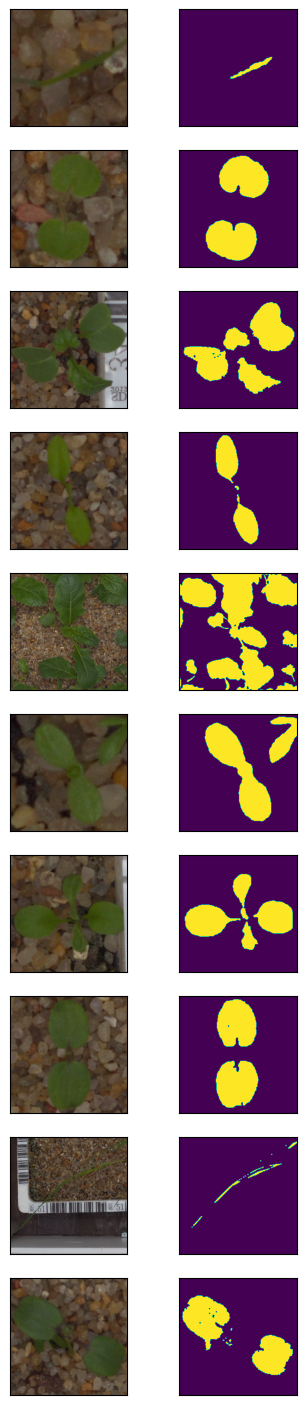

In [11]:
# Affichage de quelques éléments d'un batch
imgs_batch, masks_batch = next((iter(train)))
fig, ax = plt.subplots(10,2, subplot_kw = dict(xticks=[], yticks=[]), figsize=(4,18))
for i in range(10):
    ax[i,0].imshow(imgs_batch[i])
    ax[i,1].imshow(masks_batch[i])

In [12]:
# Vérification de l'encodage d'un masque
set(plt.imread(df_segmentation.annotation[0]).ravel())

{0.0, 1.0}

Les masques sont bien codés selon des 0 et des 1 uniquement.

# Modèle Unet

In [9]:
nb_classes = 2

# Construction fonctionelle du modèle
inputs = Input((224,224,3))
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(nb_classes, 1, activation = 'softmax')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ['SparseCategoricalAccuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_19 (Conv2D)             (None, 224, 224, 16  2064        ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 224, 224, 32  0           ['conv2d_1[0][0]',               
                                )                                 'conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 16  2320        ['conv2d_20[0][0]']              
          

# Entraînement du modèle

In [10]:
# Définition des callbacks
reduce_learning_rate = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=3,
                                         verbose=1)

# Définition d'un callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [11]:
def model_load_and_fit(checkpoint_filepath, csvlogger_filepath, loadweights_filepath=None,lr=1.e-3,nb_epochs=20):
    
    """
    Fonction permettant de charger un éventuel modèle précédemment entraîné, de compiler et de lancer l'entraînement.
    """
    
    # Chargement des poids obtenus lors d'un précédent entraînement
    if loadweights_filepath != None:
        print("Loading model weights")
        model.load_weights(loadweights_filepath)
        
    # Compilation
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),
              loss="sparse_categorical_crossentropy",
              metrics=['SparseCategoricalAccuracy'])
    model.optimizer.lr.assign(lr)    # Assignation forcée pour éviter l'utilisation du LR chargé avec les poids (bug Keras?)
    print("Model compilation OK, learning rate =",model.optimizer.lr.numpy())
    
    # Définition du ModelCheckPoint
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_sparse_categorical_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
    # Définition du CSV Logger (enregistrement de l'historique d'entraînement)
    csv_logger = CSVLogger(csvlogger_filepath,append=True)
    
    # Entraînement
    print("Launching training")
    training_history = model.fit(train,
                                 epochs=nb_epochs,
                                 validation_data=test,
                                 callbacks=[time_callback,reduce_learning_rate, model_checkpoint,csv_logger],
                                 verbose=True)


In [12]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Unet','best_weights.ckpt')
csvlogger_filepath = Path('Unet','training_history.csv')

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath)

Compiling model
Model compilation OK, learning rate = 0.001
Launching training
Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 0.1642 - sparse_categorical_accuracy: 0.9323 
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.97111, saving model to Unet\best_weights.ckpt
75/75 [==============================] - 864s 11s/step - loss: 0.1642 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9711 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.0620 - sparse_categorical_accuracy: 0.9729 
Epoch 2: val_sparse_categorical_accuracy improved from 0.97111 to 0.97463, saving model to Unet\best_weights.ckpt
75/75 [==============================] - 868s 11s/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0597 - val_sparse_categorical_accuracy: 0.9746 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.0618 - sparse_categorical_accuracy

In [13]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 291.0 minutes.


# Résultats

In [14]:
# Fonction permettant d'afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    
def plot_history():
    training_history = pd.read_csv(csvlogger_filepath, index_col = 'epoch')
    
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['sparse_categorical_accuracy'], color='forestgreen')                    
    ax[0].plot(training_history['val_sparse_categorical_accuracy'], color='lawngreen')                      
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")                
    ax[0].set_xlabel("Epoch")           
    ax[0].set_ylabel("Accuracy")        
    ax[0].legend(['train', 'test'], loc='best');                                                               

    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'test'], loc='best');

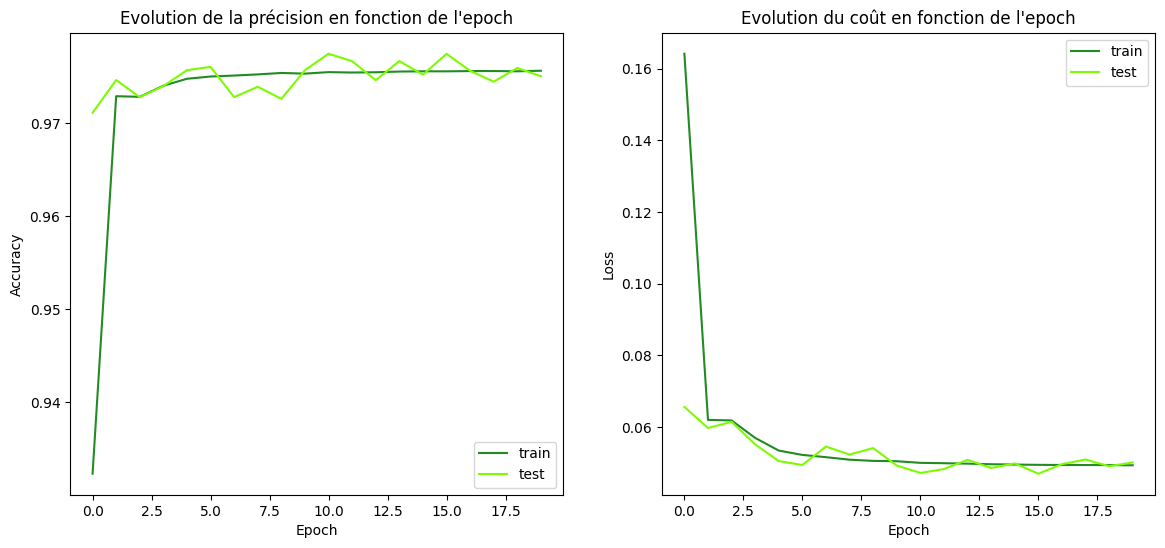

In [15]:
plot_history()

In [16]:
# Générer un batch du dataset test
X_test, y_test = next(iter(test))

In [17]:
print(X_test.shape)
print(y_test.shape)

(32, 224, 224, 3)
(32, 224, 224, 1)


In [18]:
# Calcul des prédictions du modèle pour un batch du jeu de test
y_pred = model.predict(X_test).argmax(-1)

1/1 [==============================] - 2s 2s/step


In [19]:
def compare(number, X = X_test, y = y_test, y_pred = None):
    
    """
    Fonction permettant d'afficher pour un certain nombre d'images issu d'un batch, l'image originelle, le masque associé 
    ainsi que le masque prédit par le modèle
    """
    
    if number > len(X):
        print("Out of range.")
        
    else:     
        if y_pred is None:
            y_pred = model.predict(X).argmax(-1)
        y_pred = y_pred[..., tf.newaxis]

        fig, ax = plt.subplots(number, 3, figsize=(12, number*3), subplot_kw = dict(xticks=[], yticks=[]))

        for j, i in enumerate(np.random.randint(len(X_test), size = number)):

                ax[j,0].imshow(X[i])
                ax[j,0].set_title('Input Image')

                ax[j,1].imshow(y[i])
                ax[j,1].set_title('True Mask')

                ax[j,2].imshow(y_pred[i])
                ax[j,2].set_title('Predicted Mask')
        plt.show() 

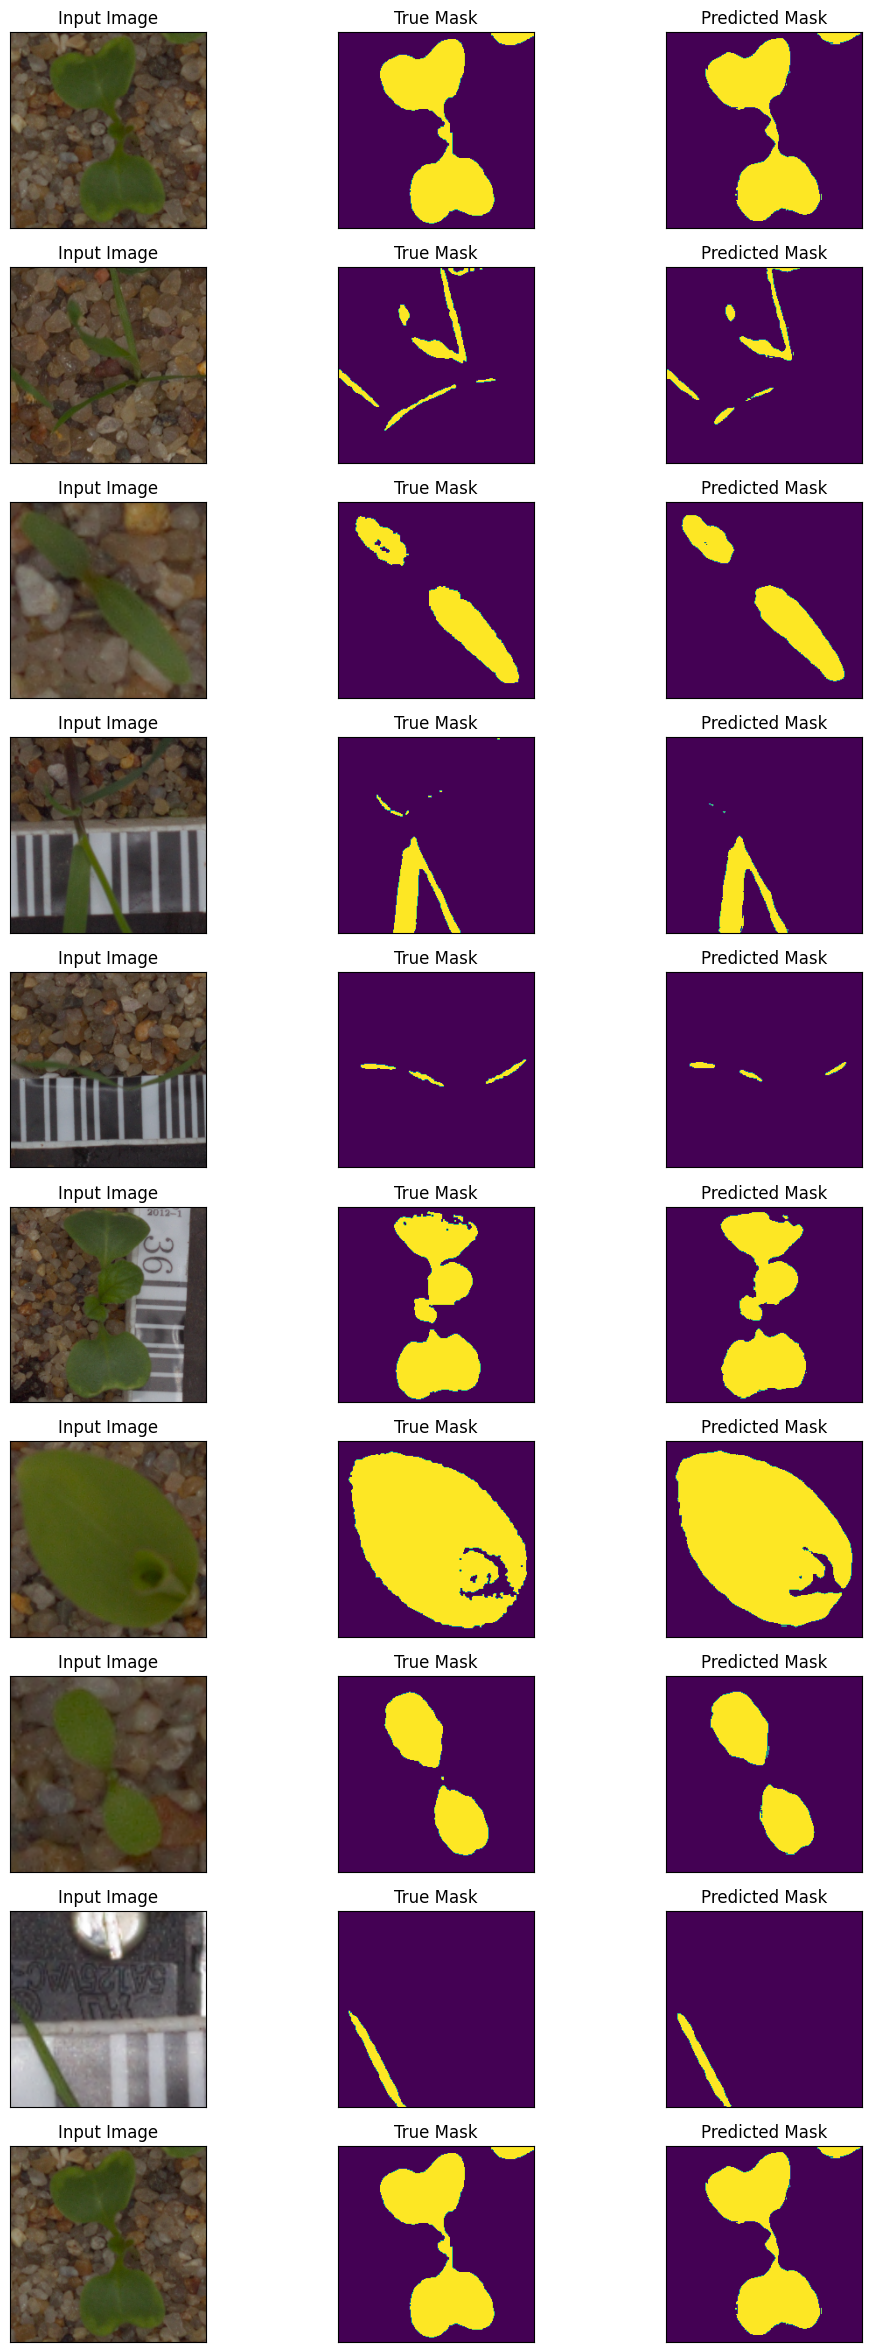

In [20]:
compare(10, y_pred = y_pred)

In [21]:
def show_predicted_segment(number, X = X_test, y = y_test, y_pred = None):
    
    """
    Fonction permettant d'afficher pour un certain nombre d'images issu d'un batch : l'image originelle, 
    l'image segmentée par seuillage colorimétrique ainsi que l'image segmentée via l'utilisation du masque prédit par le modèle.
    """
    
    if number > len(X):
        print("Out of range")
        
    else:     
        if y_pred is None:
            y_pred = model.predict(X).argmax(-1)
        y_pred = y_pred[..., tf.newaxis]
        
        X = X.numpy()

        fig, ax = plt.subplots(number, 3, figsize=(12, number*3), subplot_kw = dict(xticks=[], yticks=[]))

        for j, i in enumerate(np.random.randint(len(X_test), size = number)): #np.random.choice marche aussi
            
            ax[j,0].imshow(X[i])
            ax[j,0].set_title('Original Image')

            ax[j,1].imshow(cv2.bitwise_and(X[i], X[i], mask = np.uint8(y[i])))
            ax[j,1].set_title('Segmented image with real mask')
                
            ax[j,2].imshow(cv2.bitwise_and(X[i], X[i], mask = np.uint8(y_pred[i])))
            ax[j,2].set_title('Segmented image with predicted mask')

        plt.show() 

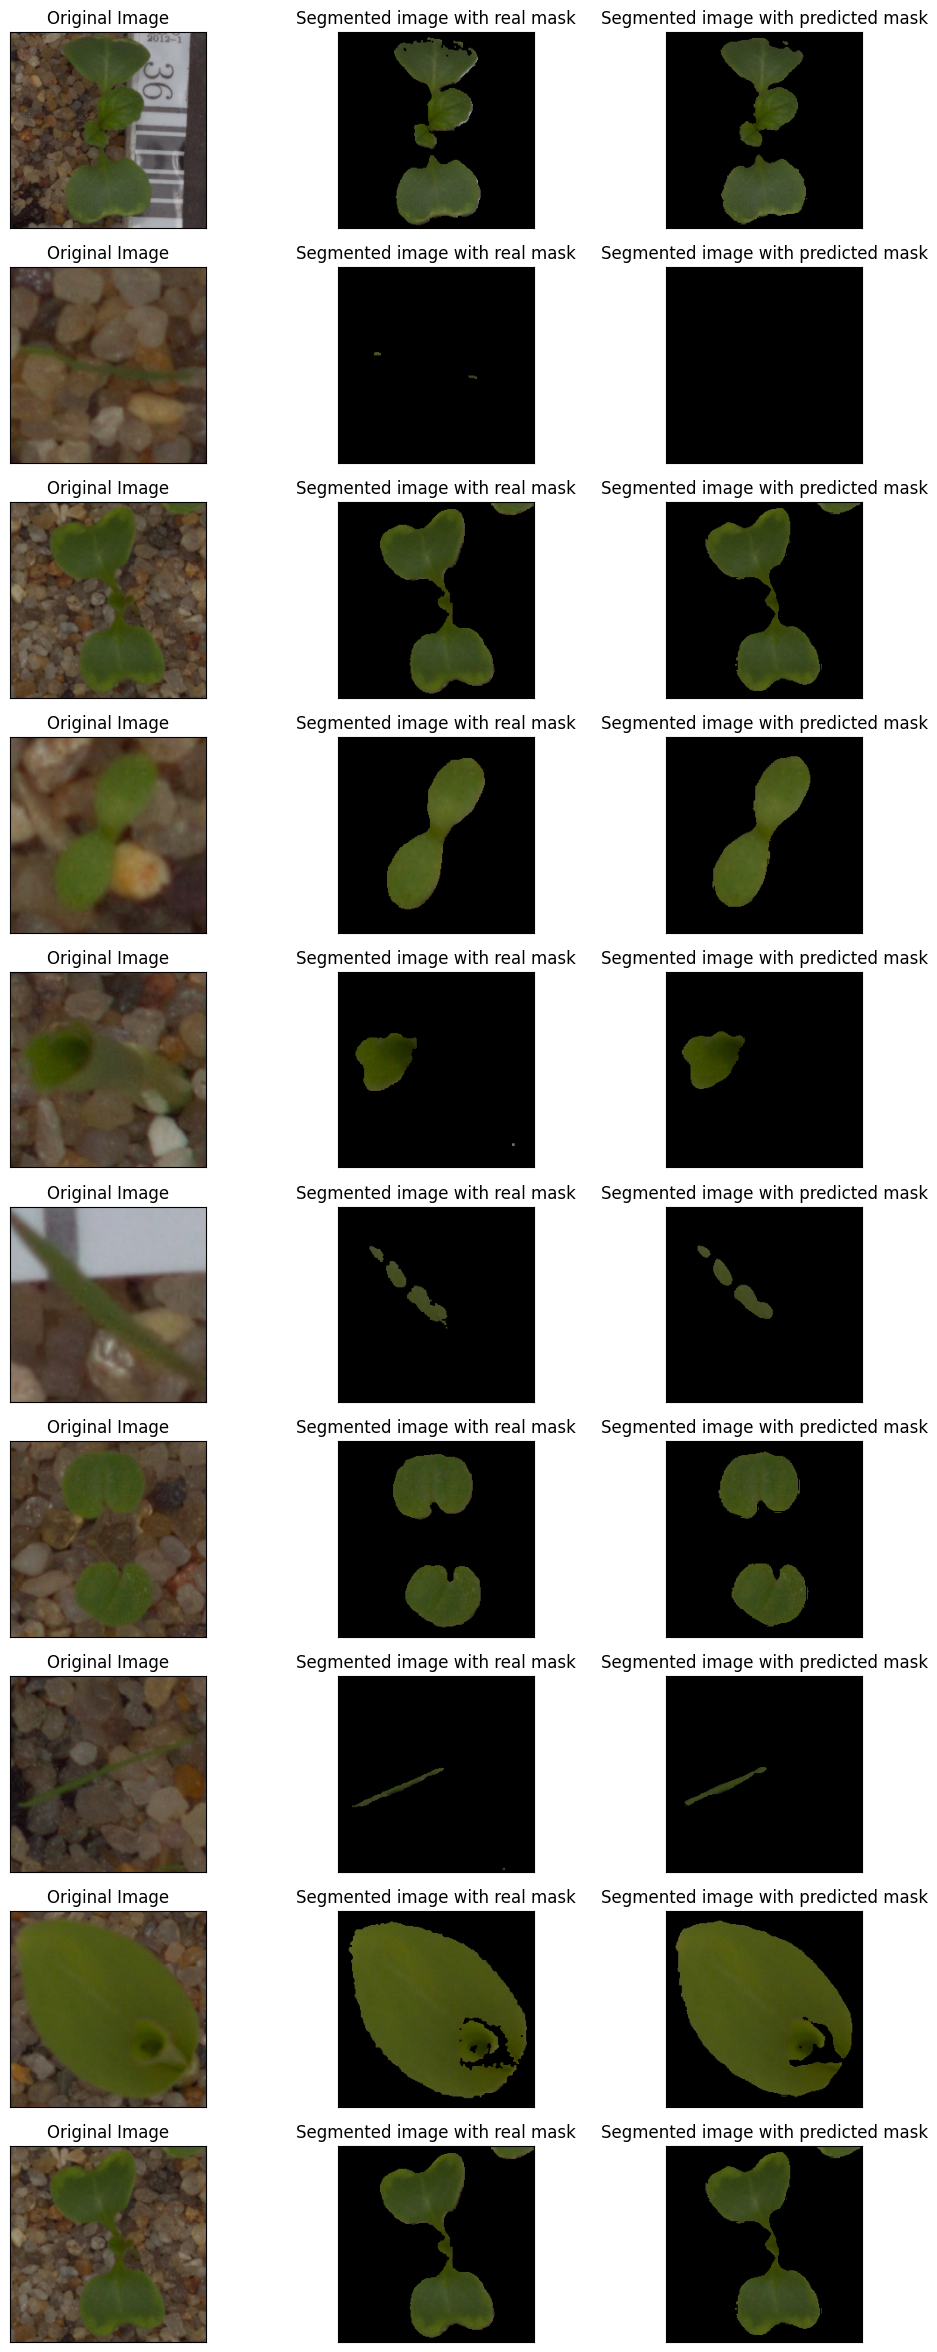

In [22]:
show_predicted_segment(10, y_pred= y_pred)

In [23]:
# Sauvegarde du modèle
model.save("unet.h5")

Le modèle a bien appris suite à son entraînement comme le prouvent les résultats de segmentation avec prédiction.
Néanmoins il est à noter que ses performances sont biaisées car les masques sur lesquels il se base afin d'évaluer les pertes sont eux-même loin d'être optimaux...
L'étude et comparaison des prédictions du modèle de classification sur ces images segmentées par prédiction du masque avec les images segmentées par seuillage font l'objet d'un autre notebook.